# Text Detection for PicText
by Len Huang

An exploratory notebook to learn `PyTorch`. Following https://towardsdatascience.com/how-to-train-an-image-classifier-in-pytorch-and-use-it-to-perform-basic-inference-on-single-images-99465a1e9bf5

Note that much of the text below is copied / modified from the above article. I do not intend to use this for any copyright infrigement, only educational purposes.

In [68]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.autograd import Variable

# Prep Work

### File Structure

PyTorch expects the data to be organized by folders with one folder for each class. Most of the other PyTorch tutorials and examples expect you to further organize it with a training and validation folder, but that's too much work. Instead we’ll define the train / validation dataset loader, using the SubsetRandomSampler for the split:

In [69]:
data_dir = 'images/train'
def load_split_train_test(datadir, valid_size = .2):
    train_transforms = transforms.Compose([transforms.Resize(224),
                                       transforms.ToTensor(),
                                       ])
    test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                      ])
    train_data = datasets.ImageFolder(datadir,       
                    transform=train_transforms)
    test_data = datasets.ImageFolder(datadir,
                    transform=test_transforms)
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    from torch.utils.data.sampler import SubsetRandomSampler
    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=64)
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=64)
    return trainloader, testloader
trainloader, testloader = load_split_train_test(data_dir, .2)

# WE'LL NEED TO DEFINE CLASSES FOR LATER
classes = trainloader.dataset.classes
print(trainloader.dataset.classes)

['add', 'equal', 'minus', 'times']


### GPU Check / Load Pre-trained Model
Next we’ll determine whether we have GPU or not. I assume that if you’re doing this you have a GPU-powered machine, otherwise the code will be at least 10 times slower. But it’s a good idea to generalize and check for the GPU availability.
We’ll also load a pretrained model. For this case, I chose ResNet 50.

Here are a list of other pretrained models: https://pytorch.org/docs/stable/torchvision/models.html

In [70]:
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
model = models.resnet50(pretrained=True)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Preparing Stuff for Neural Networks
1. We have to freeze the pre-trained layers, so we don’t backprop through them during training. 
2. Re-define the final fully-connected the layer, the one that we’ll train with our images.
3. Create the criterion (the loss function) .
4. Pick an optimizer (Adam in this case) and learning rate.

In [71]:
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 10),
                                 nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Training Your Model

There’s just one epoch in this example but in most cases you’ll need more. The basic process is quite intuitive from the code: You load the batches of images and do the feed forward loop. Then calculate the loss function, and use the optimizer to apply gradient descent in back-propagation. During validation, don’t forget to set the model to eval() mode, and then back to train() once you’re finished.

I've defined a function so we can do the validation then the training in an easier way - Len

In [75]:
def train_model(train):
    epochs = 1
    steps = 0
    running_loss = 0
    print_every = 1
    train_losses, test_losses = [], []
    for epoch in range(epochs):
        for inputs, labels in trainloader:
            steps += 1
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            logps = model.forward(inputs)
            loss = criterion(logps, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            if steps % print_every == 0:
                test_loss = 0
                accuracy = 0
                # validation mode
                if train:
                    model.train()
                # training mode
                else: 
                    model.eval()
                with torch.no_grad():
                    for inputs, labels in testloader:
                        inputs, labels = inputs.to(device), labels.to(device)
                        logps = model.forward(inputs)
                        batch_loss = criterion(logps, labels)
                        test_loss += batch_loss.item()

                        ps = torch.exp(logps)
                        top_p, top_class = ps.topk(1, dim=1)
                        equals = top_class == labels.view(*top_class.shape)
                        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                train_losses.append(running_loss/len(trainloader))
                test_losses.append(test_loss/len(testloader))                    
                print(f"Epoch {epoch+1}/{epochs}.. "
                      f"Train loss: {running_loss/print_every:.3f}.. "
                      f"Test loss: {test_loss/len(testloader):.3f}.. "
                      f"Test accuracy: {accuracy/len(testloader):.3f}")
                running_loss = 0
                model.train()
    torch.save(model, 'symbol_init_model.pth')
    return train_losses, test_losses
    
train_losses, test_losses = train_model(True)
train_losses, test_losses = train_model(False)

Epoch 1/1.. Train loss: 2.579.. Test loss: 2.088.. Test accuracy: 0.385
Epoch 1/1.. Train loss: 1.738.. Test loss: 0.834.. Test accuracy: 0.513
Epoch 1/1.. Train loss: 0.637.. Test loss: 0.300.. Test accuracy: 0.949
Epoch 1/1.. Train loss: 0.462.. Test loss: 1.332.. Test accuracy: 0.564
Epoch 1/1.. Train loss: 0.684.. Test loss: 1.243.. Test accuracy: 0.615
Epoch 1/1.. Train loss: 1.299.. Test loss: 0.903.. Test accuracy: 0.692


### Plot Your Results

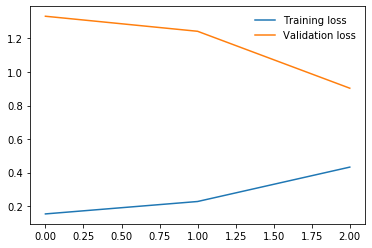

In [76]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

# Testing Your Model

Now on to the second part. So you trained your model, saved it, and need to use it in an application. For that, you’ll need to be able to perform simple inference on an image. Let's load our training data just to use as testing data. _(This is bad practice but you get the idea... - Len)_

In [77]:
data_dir = 'images/test'
test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                     ])

Then again we check for GPU availability, load the model and put it into evaluation mode (so parameters are not altered):

In [78]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=torch.load('symbol_init_model.pth')
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Predicting Class

This function will predict the class of an image.

In [79]:
def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

Now for easier testing, I also created a function that will pick a number of random images from the dataset folders:

In [80]:
def get_random_images(num):
    data = datasets.ImageFolder(data_dir, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, 
                   sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

Finally, to demo the prediction function, I get the random image sample, predict them and display the results:

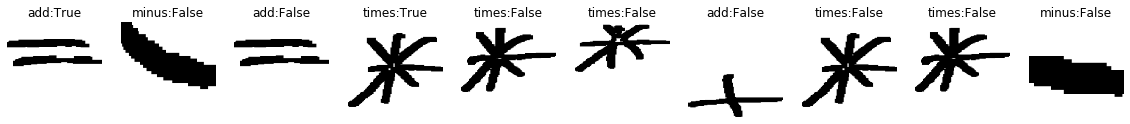

In [81]:
image_count = 10
plt_dim = image_count * 2

to_pil = transforms.ToPILImage()
images, labels = get_random_images(image_count)
fig=plt.figure(figsize=(plt_dim,plt_dim))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    sub.set_title(str(classes[index]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()